In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.002
num_epoch=100

In [2]:
#data normalization
cifar_train= dset.CIFAR10("CIFAR10/", train=True, 
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),        
                           ]), target_transform=None, download=True)
cifar_test= dset.CIFAR10("CIFAR10/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(), 
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                         ]), target_transform=None, download=True)


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이:  50000
cifar_test 길이:  10000
image data 형태: torch.Size([3, 32, 32])
label:  9


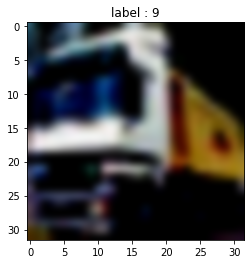

In [3]:
#실행 x
print ("cifar_train 길이: ", len(cifar_train))
print ("cifar_test 길이: ", len(cifar_test))

#데이터 하나 형태
image, label=cifar_train.__getitem__(1)
print ("image data 형태:", image.size())
print ("label: ", label)

img=image.numpy()

r,g,b=img[0, :, :], img[1,:,:], img[2,:,:]

img2=np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2]=r,g,b

plt.title("label : %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
  correct=0
  total=0

  for j, [imgs, labels] in enumerate(dloader):
      img=Variable(imgs, volatile=True).cuda()
      label=Variable(labels).cuda()

      output=imodel.forward(img)
      _, output_index=torch.max(output, 1)

      total+=label.size(0)
      correct+=(output_index==label).sum().float()
  print("Accuracy of Test Data: {}".format(100*correct/total))

In [5]:
train_loader= torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader= torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
#batch normalization
#dropout
#ELU
class CNN(nn.Module):
    def __init__(self):
      super(CNN,self).__init__()
      self.layer=nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
      )
      self.fc_layer=nn.Sequential(
          nn.Linear(64*8*8, 100),
          nn.ELU(),
          nn.Dropout2d(0.2),
          nn.BatchNorm1d(100),
          nn.Linear(100,10)
      )

      #weight initialization
      for m in self. modules():
        if isinstance(m, nn.Conv2d):
          init.kaiming_normal(m.weight.data)
          m.bias.data.fill_(0)
        if isinstance(m, nn.Linear):
          init.kaiming_normal(m.weight.data)
          m.bias.data.fill_(0)

    def forward(self,x):
      out=self.layer(x)
      out=out.view(batch_size, -1)
      out=self.fc_layer(out)

      return out
model=CNN().cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [11]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
#adam optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

#learning rate decay
#scheduler=lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

model.train()
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output, y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j,loss)

0 tensor(0.2232, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(0.8076, device='cuda:0', grad_fn=<NllLossBackward>)


KeyboardInterrupt: ignored

In [7]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 76.63999938964844


기본 훈련

In [ ]:
netname='./nets/my_net01.pkl'
torch.save(model, netname, )

In [ ]:
netname='./nets/my_net01.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 18.639999389648438


Learning rate decay(미리 정의된 개별적인 고정 학습률)

In [ ]:
netname='./nets/my_net02.pkl'
torch.save(model, netname, )

In [ ]:
netname='./nets/my_net02.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.55999755859375


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Learning rate decay(지수 기반 스케줄링)

In [ ]:
netname='./nets/my_net03.pkl'
torch.save(model, netname, )

In [ ]:
netname='./nets/my_net03.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.8699951171875


지수 기반 스케쥴링: epoch=100

In [ ]:
netname='./nets/my_net04.pkl'
torch.save(model, netname, )

In [ ]:
netname='./nets/my_net04.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 65.97000122070312


지수 100+weight 초기화+adam 옵티마이저

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
netname='./drive/MyDrive/Colab Notebooks/nets/my_net05.pkl'
torch.save(model, netname, )

In [ ]:
netname='./nets/my_net05.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.38999938964844


In [ ]:
netname='./drive/MyDrive/Colab Notebooks/nets/my_net05.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 66.38999938964844


epoch=100+data normalization+batch 정규화+weight 초기화+adam+Learning rate decay(지수 기반 스케줄링)

In [ ]:
netname='./drive/MyDrive/Colab Notebooks/nets/my_net06.pkl'
torch.save(model, netname, )

In [ ]:
netname='./drive/MyDrive/Colab Notebooks/nets/my_net06.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 74.56999969482422


epoch=100+data normalization+batch 정규화+dropout+ELU함수+weight 초기화+adam+Learning rate decay(지수 기반 스케줄링)

In [8]:
netname='./drive/MyDrive/Colab Notebooks/nets/my_net08.pkl'
torch.save(model, netname, )

In [10]:
netname='./drive/MyDrive/Colab Notebooks/nets/my_net08.pkl'

model=torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 76.63999938964844
